# Kaggle Competition: Don't Call Me Turkey

This notebook contains my model for the Kaggle competition Don't Call Me Turkey. I used a dense neural net crated with Keras/Tensorflow. My final model had an accuracy of about 96% (ROC score of 0.99).

**Objective:** To classify a sound clip as whether or not it was made by a turkey 

**Data set:** From Kaggle[1]. The provided data contained audio encodings created with AudioSet’s VGGish tool. 


[1]:https://www.kaggle.com/c/dont-call-me-turkey/data

In [3]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train = pd.read_json('train.json')
train.head()

,audio_embedding,end_time_seconds_youtube_clip,is_turkey,start_time_seconds_youtube_clip,vid_id
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",70,0,60,kDCk3hLIVXo
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",40,1,30,DPcGzqHoo7Y
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",240,1,230,7yM63MTHh5k
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",520,1,510,luG3RmUAxxM
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",10,0,0,PIm3cjxTpOk


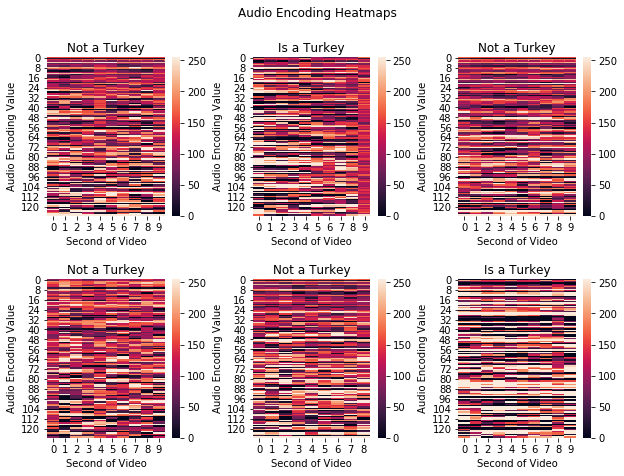

In [4]:
plt.figure(figsize=[10, 7])
for i in range(1, 7):
    plt.subplot(2, 3, i)
    which_row = random.randint(1, len(train.is_turkey))
    sns.heatmap(data = np.matrix(train.audio_embedding[which_row]).T)
    plt.xlabel("Second of Video"); plt.ylabel("Audio Encoding Value");
    if train.is_turkey[which_row] == 0:
        plt.title("Not a Turkey")
    else:
        plt.title("Is a Turkey")
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.suptitle('Audio Encoding Heatmaps');

### Preparing Data and Building Model

In [5]:
def PrepareData(audio_data,vid_duration):
    X = np.ones((len(audio_data), 1280+1) )*0.5
    for i in range(0, len(audio_data)):
        unrolled_matrix = np.matrix(audio_data[i]).getA1()
        X[i, 0:len(unrolled_matrix)] = unrolled_matrix/255.0
        X[i, len(unrolled_matrix)] = vid_duration[i]/10.0
    return X

X = PrepareData(train.audio_embedding, train.end_time_seconds_youtube_clip - train.start_time_seconds_youtube_clip)

trainX, valX, trainy, valy = train_test_split(X, train.is_turkey, test_size=0.4)
valX, testX, valy, testy = train_test_split(valX, valy, test_size = 0.5)
print("Number of Training Examples:", len(trainy))
print("Number of Validation Examples:", len(valy))
print("Number of Test Set Examples:", len(testy))

Number of Training Examples: 717
Number of Validation Examples: 239
Number of Test Set Examples: 239


In [6]:
model = keras.Sequential([
    keras.layers.Dense(15, activation = tf.nn.relu, input_shape = (1281,)), 
    keras.layers.Dense(40, activation = tf.nn.relu ),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics = ['acc'])
print(model.summary())


history = model.fit(trainX, trainy, epochs=12, validation_data=(valX, valy))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                19230     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 19,911
Trainable params: 19,911
Non-trainable params: 0
_________________________________________________________________
None
Train on 717 samples, validate on 239 samples
Epoch 1/12
717/717 [==============================] - 1s 723us/step - loss: 0.5735 - acc: 0.7099 - val_loss: 0.3893 - val_acc: 0.9079
Epoch 2/12
717/717 [==============================] - 0s 51us/step - loss: 0.2891 - acc: 0.9163 - val_loss: 0.2119 - val_acc: 0.9205
Epoch 3/12
717/717 [==============================] - 0s 51us/step - loss: 0.1852 - 


Final Validation Set Scores:
ROC_AUC score: 0.990447242726878
Accuracy Score: 0.9623430962343096

Total # of Turkeys in Validation Set: 98
Sum of Predictions on Validation Set: [97.103966]


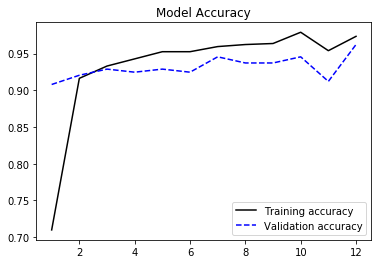

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'k-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b--', label = 'Validation accuracy')
plt.legend()
plt.title('Model Accuracy');

pred = model.predict(valX)

print("\nFinal Validation Set Scores:")
print("ROC_AUC score:", roc_auc_score(y_score=pred, y_true=valy))
print("Accuracy Score:", accuracy_score(pred>0.5, valy))

print("\nTotal # of Turkeys in Validation Set:", sum(valy))
print("Sum of Predictions on Validation Set:", sum(pred))

### Checking metrics on test set predictions

In [8]:
pred = (model.predict(testX)) 
print("\nROC_AUC score:", roc_auc_score(y_score=pred, y_true=testy))
print("Accuracy Score:", accuracy_score(pred>0.5, testy))


ROC_AUC score: 0.9902301346070344
Accuracy Score: 0.9581589958158996


### Making Predictions for Kaggle Submission

In [9]:
test = pd.read_json('test.json')
X_test = PrepareData(test.audio_embedding,test.end_time_seconds_youtube_clip - test.start_time_seconds_youtube_clip)

pred = model.predict(X_test) 
d = {'vid_id':np.array(test.vid_id), 'is_turkey':pred[:, 0]}
result = pd.DataFrame(data = d)
result.to_csv("Predictions.csv", index=False)
result.head(10)

,vid_id,is_turkey
0,pyKh38FXD3E,0.000444
1,THhP1idrWXA,0.000162
2,jsw3T6GY2Nw,0.023751
3,nFkXTMHcjMU,0.002161
4,Au8g9kAlrLQ,0.712064
5,tgk3DUpRI-w,0.004317
6,BczNwyCGlH4,0.005510
7,zB5eXpmJDTM,0.000140
8,099z8epFcfc,0.993394
9,lQ8DMnq415o,0.991921
